In [6]:
from context import continuous_BP as cbp
from context import mmd as mmd
from context import operators as myops
from context import lasso as ls
from context import helper

In [16]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

from numpy import linspace
from importlib import reload  # Python 3.4+
reload(ls)
reload(myops)
reload(mmd)
reload(cbp)

NameError: name '__file__' is not defined

In [214]:
#SR Lasso certificate

def SRLasso_certificate(a0,shift,xgrid, tau, Phi, dPhi):
    
    def scaleAfun(x):
        scaleA = 1/np.sqrt(np.sum(np.abs(dPhi(x))**2,axis=0))
        return scaleA
    
    scaleA = scaleAfun(xgrid)
    A0 = Phi(xgrid)
    A1 = tau*scaleA[None,:]*dPhi(xgrid)
    X_I = np.concatenate((A0, A1),1)
    
    b0 = -a0*shift/tau/scaleA
    magnitude = np.sqrt(np.abs(a0)**2 + np.abs(b0)**2)
    sgn = np.concatenate((a0/magnitude,b0/magnitude))
    coeffs = X_I@ ( np.linalg.inv(np.conjugate(X_I.T)@X_I)@sgn )

    eta = lambda x: np.conjugate(Phi(x).T) @coeffs
    eta_d = lambda x: scaleAfun(x)*(np.conjugate(dPhi(x).T) @coeffs)
    return lambda x: np.abs(eta(x))**2 + tau**2 * np.abs(eta_d(x))**2

#CBP certificates
def cBP_certificates(a0,h, Phi,dPhi,xgrid):
    
    X_I = np.concatenate((Phi(xgrid),dPhi(xgrid)),1)
    sgn =  np.concatenate((np.ones(len(a0),),np.zeros(len(a0),)))
    coeffs = X_I@(np.linalg.pinv(np.conjugate(X_I.T)@X_I)@sgn)
    eta = lambda x: np.real( np.conjugate( Phi(x).T ) @coeffs )
    eta_d = lambda x: np.real( np.conjugate( dPhi(x).T) @coeffs )
    return lambda x: eta(x)+h/2*eta_d(x), lambda x: eta(x)-h/2*eta_d(x)



In [215]:


def getOperator(op):
    if op == 'Fourier':
        #Fourier
        fq = 5

        x0,x1=0,1
        Phi, dPhi = myops.getFourierOp(fq)

    elif op=='Gaussian':
        #Gaussian
        m = 20
        sigma = 0.1
        tvec = linspace(0,1,m)

        x0,x1=0,1
        Phi, dPhi = myops.getGaussianOp(tvec,sigma)
    elif op=='Laplace':
        #Laplace
        T = 100
        x0,x1=0,8
        tvec = linspace(x0,x1,T)
        
        Phi, dPhi = myops.getLaplaceOp(tvec)
    else:
        print('Not defined!!')
    xgrid = linspace(x0,x1,N)
    return Phi,dPhi,xgrid



In [216]:
plot = False
op = 'Gaussian'
#op = 'Fourier'
#op = 'Laplace'

certmax_srl = []
certmax_cbp = []

supp_srl = []
supp_cbp = []
Nvals = [10,15,20,25,30,35,40,45,50]

Nvals = np.arange(10,50,2)
for N in Nvals:
#N= 30 #grid size
    Phi, dPhi,xgrid = getOperator(op)
    x0,x1 = min(xgrid),max(xgrid)
    A = Phi(xgrid)
    dA = dPhi(xgrid)
    scaleA = 1/np.sqrt(np.sum(np.abs(dA)**2,axis=0))
    h = xgrid[1]-xgrid[0]

    # true support
    I = np.array([int(N*0.4), int(N*.7)])
    spacing = 0.2 #how far into the grid the spikes are
    a0 = np.array([2,3])

    #calculate the ground truth b_0
    tau = 1
    f0 = SRLasso_certificate(a0,spacing*h,xgrid[I], tau, Phi, dPhi)
    fvec = f0(xgrid)
    fvec[I] = 0
    certmax_srl.append(np.max(fvec))
    
    #plot certificate on grid
    if plot:
        plt.plot([x0,x1], [1,1], 'k--')
        xgrid_full = np.linspace(x0,x1,10000)
        plt.plot(xgrid_full, f0(xgrid_full),'r')
        plt.plot(xgrid, f0(xgrid),'rx',markersize=10)

        plt.savefig('results/'+str(N)+op+'SRL_certificate.png', bbox_inches='tight',dpi=200, transparent=True)

        plt.yticks([1])
        plt.ylim([0.99,1.01])
        plt.savefig('results/'+str(N)+op+'SRL_certificate_zoom.png', bbox_inches='tight',dpi=200, transparent=True)
        plt.show()
    
    

    #CPB certificate
    g1,g2  = cBP_certificates(a0,h, Phi,dPhi,xgrid[I])
    gvec = np.maximum(g1(xgrid),g2(xgrid))
    gvec[I] = 0
    certmax_cbp.append(np.max(gvec))
    
    if plot:
        plt.plot([x0,x1], [1,1], 'k--')
        xgrid_full = np.linspace(x0,x1,10000)
        plt.plot(xgrid_full, g1(xgrid_full), 'r', markersize=10)
        plt.plot(xgrid_full, g2(xgrid_full), 'b', markersize=10)
        plt.plot(xgrid, g1(xgrid), 'rx', label=r'$\eta+\frac{h}{2} D\eta$',markersize=10)
        plt.plot(xgrid, g2(xgrid), 'bx', label=r'$\eta-\frac{h}{2} D\eta$',markersize=10)
        plt.legend( fontsize="16")
        plt.yticks([1])
        plt.savefig('results/'+str(N)+op+'cbp_certificate.png', bbox_inches='tight',dpi=200, transparent=True)

        plt.ylim([0.9,1.08])
        plt.savefig('results/'+str(N)+op+'cbp_certificate_zoom.png', bbox_inches='tight',dpi=200, transparent=True)
        plt.show()

    
    t0 = xgrid[I]+spacing*h

    y_obs =  Phi(t0)@a0

    tol=1e-2
    alpha = 0.3
    #cBP
    a_cbp, shift_cbp= cbp.cBP_1D( A, dA, h, y_obs,alpha )
    a_cbp, x_cbp = prune(a_cbp,shift_cbp + xgrid,tol)

    #SR Lasso
    a,shift = cbp.SRLasso(A, dA, y_obs,alpha,tau)
    a, x = prune(a,  xgrid+shift ,tol)
    
    supp_srl.append(len(a))
    supp_cbp.append(len(a_cbp))

    if plot:
        plt.plot(xgrid, 0*xgrid, 'kx')
        markerline, stemline, baseline, = plt.stem(x,a, label='SR Lasso',  linefmt='c', markerfmt='cs', basefmt='c-')
        plt.setp(stemline, linewidth = 1.25)
        plt.setp(markerline, markersize = 14)

        markerline, stemline, baseline, = plt.stem(x_cbp,a_cbp,label='cBP',  linefmt='k', markerfmt='kd', basefmt='k-')
        plt.setp(stemline, linewidth = 1.25)
        plt.setp(markerline, markersize = 12)


        plt.stem(t0,a0,'r', label='Ground truth')

        plt.legend(fontsize=16)

        plt.savefig('results/'+str(N)+op+'rec', bbox_inches='tight',dpi=200, transparent=True)
        plt.show()

20 20


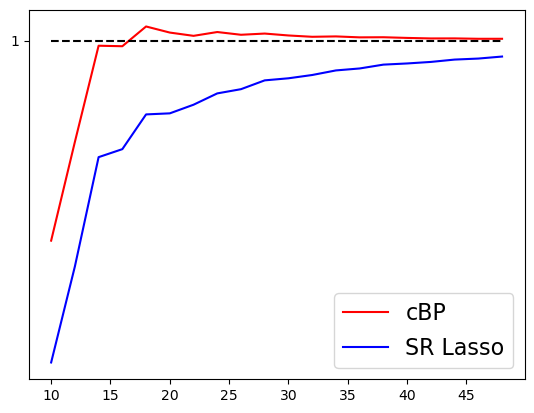

In [217]:
Nvals = np.array(Nvals)
print(len(Nvals),len(certmax_srl))
plt.plot(Nvals,certmax_cbp,'r',label='cBP')
plt.plot(Nvals,certmax_srl,'b',label='SR Lasso')
plt.legend(fontsize=16)
plt.plot(Nvals,Nvals*0+1, 'k--')
plt.yticks([1])
plt.savefig('results/'+op+'certificate_vals.png', bbox_inches='tight',dpi=200, transparent=True)



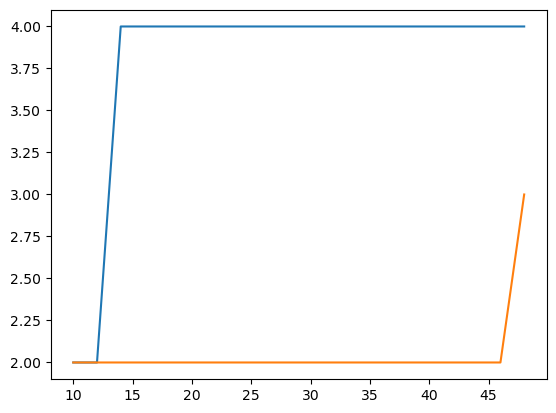

In [218]:
plt.plot(Nvals,supp_cbp)
plt.plot(Nvals,supp_srl)